# ELG7113 Machine Learning for Adaptive and Intelligent Control Systems

Student: Derek Boase

Std Num: 300043860

e-mail: dboas065@uottawa.ca

assignment GitHub: git@github.com:derekboase/Adaptive_Control_Code.git

In [1]:
import matplotlib.pyplot as plt
import control as co
import numpy as np
import sympy as sp

from sympy.abc import e, p, beta, gamma, omega, theta, zeta
from scipy.integrate import odeint
from numpy import cos, sin, pi

## Question 1: MIT Rule

In [2]:
y, ym, ydot, yddot, u, uc = sp.symbols('y,y_m,\dot{y},\ddot{y},u,u_c')
theta_1, theta_2 = sp.symbols('theta_1,theta_2')
a,b,am,bm = sp.symbols('a,b,a_m,b_m')

model = sp.Eq(yddot, -a*ydot + b*u)
u_eq = theta_1*(y - uc) - theta_2*ydot
model_u_sub = sp.Eq(sp.solve(sp.expand(model.subs(u, u_eq)), b*theta_1*uc)[0], b*theta_1*uc)
model_p = sp.Eq((-p**2 - p*(a+b*theta_2) + b*theta_1)*y, b*theta_1*uc) 


Gm = omega**2/(p**2 + 2*zeta*omega*p + omega**2)
ym_eq = sp.Eq(ym, Gm*uc)

### Q1.1: Derivation of MIT Rule Adaptation Laws

The model of the system is given by, 

{{model}}

where {{y}} is the output and {{u}} is the input. The adjustment law of the controller has two parameters, {{theta_1}} and {{theta_2}}, such that the input to the system is given as, 

{{sp.Eq(u, u_eq)}}

Substituting the input equation into the model equation gives,

{{model_u_sub}}

To solve for $y(t)$ the differential operator is used such that $p = \frac{d}{dt}$. With this substitution, the model is then given as, 

{{model_p}}

In [3]:
model_p = sp.Eq(y, sp.collect(sp.solve(model_p, y)[0], p))


This gives, 

{{model_p}}

To find the values of {{theta_1}} and {{theta_2}} for perfect model following, we consider the given model, 

{{ym_eq}}

By comparing the numerators of the model and the reference model, we find {{theta_1}} to be, 

In [4]:
num, denum = sp.fraction(model_p.rhs)
num_m, denum_m = sp.fraction(ym_eq.rhs)
theta_1_MF = sp.Eq(theta_1, sp.solve(num - num_m, theta_1)[0])
theta_2_MF = sp.Eq(theta_2, sp.solve((denum - denum_m).subs(theta_1, theta_1_MF.rhs), theta_2)[0])

Then for perfect model following the values of the parameters should be, 

{{theta_1_MF}} 

and

{{theta_2_MF}}

Next we find the sensitivity of the error function, $\frac{\partial e(\theta_1, \theta_2)}{\partial \theta_i}$, for $i \in\{1,2\}$. One note to make is that since $y_m$ doesn't depend on the parameters the sensitivities are given by the derivation of the output, $\frac{\partial y(\theta_1, \theta_2)}{\partial \theta_i}$

In [5]:
sens_1, sens_2 = sp.symbols('de/dt_1, de/dt_2')
sensitivity_1 = sp.diff(model_p.rhs, theta_1)
sensitivity_1 = sp.Eq(sens_1, sp.simplify(sensitivity_1))
sensitivity_2 = sp.diff(model_p.rhs, theta_2)
sensitivity_2 = sp.Eq(sens_2, sp.simplify(sensitivity_2))

The evaluation of these derivatives yeilds, 

{{sensitivity_1}}

{{sensitivity_2}}

In [6]:
sensitivity_1 = sensitivity_1.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs)
sensitivity_2 = sensitivity_2.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs)

sens_1_sym = sp.expand(sensitivity_1)
sens_2_sym = sp.expand(sensitivity_2)

These are dependent on the estimated parameters and thus require substitution of the perfect model following parameters, 

{{sensitivity_1}}

{{sensitivity_2}}

In [7]:
uc_sub = sp.solve(ym_eq, uc)[0]
sensitivity_1 = sensitivity_1.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs).subs(uc, uc_sub)
sensitivity_2 = sensitivity_2.subs(theta_1, theta_1_MF.rhs).subs(theta_2, theta_2_MF.rhs).subs(uc, uc_sub)

By rearranging the equation for the reference model to solve for $u_c$ we get, 

{{sp.Eq(uc, uc_sub)}}

Substituting this into the sensitvity equations, 

{{sensitivity_1}}

{{sensitivity_2}}

Then, 

$ \dot{\theta_i} = -\gamma' e\frac{\partial e}{\partial \theta_i}$

Then the adaptation law's are given as, 

$ \dot{\theta}_1 = \gamma'e${{-sensitivity_1.rhs}}

$ \dot{\theta}_2 = \gamma'e${{-sensitivity_2.rhs}}

By defining $\gamma = \gamma'b$ we get

$ \dot{\theta}_1 = \gamma e${{-sensitivity_1.rhs/b}}

$ \dot{\theta}_2 = \gamma e${{-sensitivity_2.rhs/b}}

### Q1.2: Implementation of MIT Rule Adaptation Laws

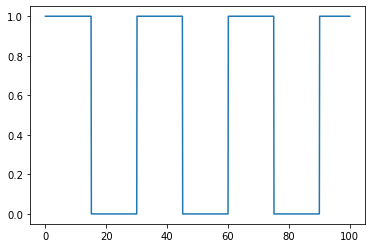

In [8]:
t = np.linspace(0, 100, 1001)
K = 2.0*1.5*0.6
C = 1.5**2 
def reference_signal(time=t):
    _uc = np.array([1])
    for _t in time[1:]:
        rat = 2.0*pi*_t/30.0
        _uc = np.concatenate((_uc, np.array([sin(rat)>= 0])), axis=0)
    return _uc
uc=reference_signal()
plt.plot(t, reference_signal())
plt.show()

In [33]:
model_p

Eq(y, -b*theta_1*u_c/(-b*theta_1 + p**2 + p*(a + b*theta_2)))

In [35]:
Ts = t[1] - t[0]

# Symbolic representation of discretized ym using zoh
ym_zoh = co.sample_system(co.tf([C], [1., K, C]), Ts=Ts, method='zoh')

ym_k_1, ym_k_2, uc_k_1, uc_k_2 = sp.symbols('y_{m}(k-1),y_{m}(k-2),u_{c}(k-1),u_{c}(k-2)')
ym_num, ym_den = ym_zoh.num[0][0], ym_zoh.den[0][0]
ym_k_sym = -ym_den[1]*ym_k_1 - ym_den[2]*ym_k_2 + ym_num[0]*uc_k_1 + ym_num[1]*uc_k_2

ym_k_func = sp.lambdify([ym_k_1, ym_k_2, uc_k_1, uc_k_2], ym_k_sym)

# Symbolic representation of discretized ym using zoh
y_zoh = co.sample_system(co.tf([theta_1], [1., K, C]), Ts=Ts, method='zoh')

# ym_k_1, ym_k_2, uc_k_1, uc_k_2 = sp.symbols('y_{m}(k-1),y_{m}(k-2),u_{c}(k-1),u_{c}(k-2)')
# ym_num, ym_den = ym_zoh.num[0][0], ym_zoh.den[0][0]
# ym_k_sym = -ym_den[1]*ym_k_1 - ym_den[2]*ym_k_2 + ym_num[0]*uc_k_1 + ym_num[1]*uc_k_2

# ym_k_func = sp.lambdify([ym_k_1, ym_k_2, uc_k_1, uc_k_2], ym_k_sym)

TypeError: The numerator and denominator inputs must be scalars or vectors (for
SISO), or lists of lists of vectors (for SISO or MIMO).

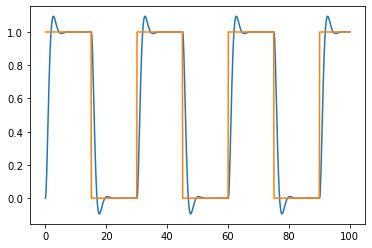

In [30]:
# t = 0

ym_vals = np.array([ym_k_func(0, 0, 0, 0)]) 
theta_1_val = np.array([0])
theta_2_val = np.array([0])
y_vals = np.array([0])


# t = 0.1
ym_vals = np.concatenate((ym_vals,
                          np.array([ym_k_func(ym_vals[0], 0, uc[0], 0)]).reshape(-1,)), 
                          axis=0)

for k, _t in enumerate(t[2:], start=2):
    ym_vals = np.concatenate((ym_vals, 
                              np.array([ym_k_func(ym_vals[k-1], ym_vals[k-2], uc[k-1], uc[k-2])]).reshape(-1,)), 
                              axis=0)
plt.plot(t, ym_vals)
plt.plot(t, uc)
plt.show()

# ABANDONED ODE SOLUTION

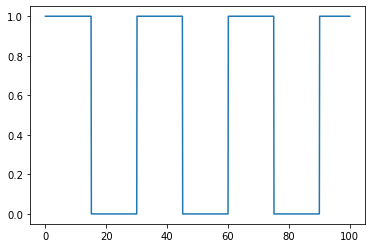

In [9]:
t = np.linspace(0, 100, 1001)
K = 2.0*1.5*0.6
C = 1.5**2 
def reference_signal(time=t):
    _uc = np.array([1])
    for _t in time[1:]:
        rat = 2.0*pi*_t/30.0
        _uc = np.concatenate((_uc, np.array([sin(rat)>= 0])), axis=0)
    return _uc
uc=reference_signal()
plt.plot(t, reference_signal())
plt.show()

In [53]:
model_p

Eq(y, -b*theta_1*u_c/(-b*theta_1 + p**2 + p*(a + b*theta_2)))

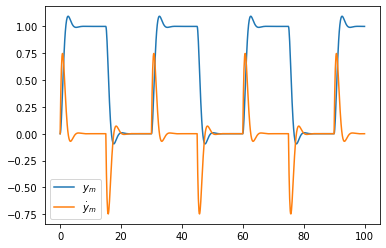

In [31]:
def model_response(init_m, t):  # init = [0: ym, 1: ym']       
    global C, K
    
    # Initial conditions 
    ym, ym_prime, ym_pprime = init_m[0], init_m[1], init_m[2]
    
    uc = sin(2.0*pi*t/30.0) >= 0
    
    # This block calculates ym and ym'
    dym_dt = ym_prime
    d2ym_dt2 = -K*dym_dt - C*ym + C*uc
    d3ym_dt3 = -K*d2ym_dt2 - C*d2ym_dt2 + C*uc
    
    return [dym_dt, d2ym_dt2, d3ym_dt3]

init_m = np.array([0, 0, 0])
model_sol = odeint(model_response, init_m, t)
ym, dym_dt, d2ym_dt2 = model_sol[:,0], model_sol[:,1], model_sol[:,2]
plt.plot(t, ym)
plt.plot(t, dym_dt)
# plt.plot(t, d2ym_dt2)
plt.legend(['$y_m$', '$\dot{y}_m$'])
plt.show()

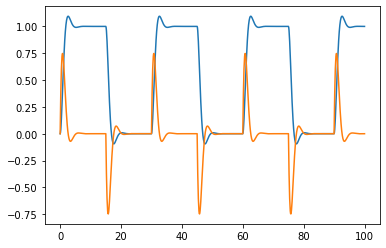

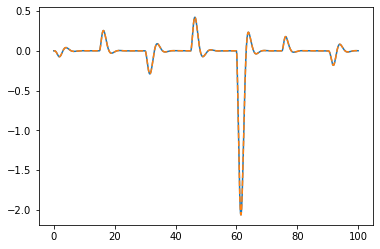

In [74]:
d2ym_dt2_arr = np.array([0])
def parameters(init, t):
    global C, K, d2ym_dt2_arr
    gamma = 1
    
    # Initial conditions
    ym, ym_prime = init[0], init[1]
    y, y_prime = init[2], init[3]
    theta1, theta1_p, theta1_pp = init[4], init[5], init[6]
    theta2, theta2_p, theta2_pp = init[7], init[8], init[9]
    
    uc = float(sin(2.0*pi*t/30.0) >= 0)
    
    # ym calculation
    dym_dt = ym_prime
    d2ym_dt2 = -K*dym_dt - C*ym + C*uc
    
    # y calculation
    dy_dt = y_prime
    d2y_dt2 = -(3 + theta2)*dy_dt + theta1*(y + uc)
    e = y-ym

    # Theta1 calculation
    M = gamma*e*(K*dym_dt + d2ym_dt2)
#     M = 0.8
    dth1_dt = theta1_p
    d2th1_dt2 = theta1_pp
    d3th1_dt3 = -K*d2th1_dt2 -C*dth1_dt + M/C
    
    # Theta2 calculation
    N = gamma*e*dym_dt
    dth2_dt = theta2_p
    d2th2_dt2 = theta1_pp
    d3th2_dt3 = -K*d2th2_dt2 - C*dth2_dt + N
    
    return [dym_dt, d2ym_dt2, dy_dt, d2y_dt2, dth1_dt, d2th1_dt2, d3th1_dt3, dth2_dt, d2th2_dt2, d3th2_dt3]

init = np.zeros(10,)
params_sol = odeint(parameters, init, t)
plt.plot(t, params_sol[:, 0])
plt.plot(t, params_sol[:, 1])

plt.show()
plt.plot(t, params_sol[:, 5])
plt.plot(t, params_sol[:, 8], '--')
plt.show()

## Question 2: Lyapunov Method